# Gradient Episodic Memory for Continual Learning

In [1]:
!pip install quadprog

import numpy as np
import matplotlib.pyplot as plt
import random
import quadprog
from torchvision import transforms
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import os
import datetime
import time




MNIST is a large database of handwritten digits that is commonly used for training and evaluating neural networks. Let's display some of the digits in the dataset to get a feel for what they look like:

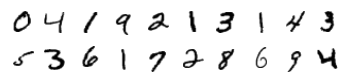

In [2]:
X_train, y_train = torch.load('mnist_train.pt')
X_test, y_test = torch.load('mnist_test.pt')

figure = plt.figure()
num_of_images = 20
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(X_train[index].numpy().squeeze(), cmap='gray_r')

## Rotating the dataset
    
Next, let's create and implement a function for rotating the MNIST dataset:

In [3]:
def rotate_dataset(dataset, rotation):
    result = torch.FloatTensor(dataset.size(0), 784)
    tensor = transforms.ToTensor()

    for i in range(dataset.size(0)):
        img = Image.fromarray(dataset[i].numpy(), mode='L')
        result[i] = tensor(img.rotate(rotation)).view(784)
    return result

## Create tasks and split into train and test sets
    


Here we define a task to consist of a subset of the MNIST data that is rotated at a particular angle. We create 20 tasks which are rotated by progressively increasing values until the maximum rotation of 180 degrees is reached for the final task. Each task is split into train and test sets, and the results are stored in mnist_rotations.pt.

In [4]:
output_file = 'mnist_rotations.pt'
tasks_num = 20
min_rotation = 0
max_rotation = 180
random_seed = 0

torch.manual_seed(random_seed)

tasks_tr = []
tasks_te = []

x_tr, y_tr = torch.load('mnist_train.pt')
x_te, y_te = torch.load('mnist_test.pt')

for t in range(tasks_num):
    min_rot = 1.0 * t / tasks_num * (max_rotation - min_rotation) + \
              min_rotation
    max_rot = 1.0 * (t + 1) / tasks_num * \
              (max_rotation - min_rotation) + min_rotation
    rot = random.random() * (max_rot - min_rot) + min_rot
    
    tasks_tr.append([rot, rotate_dataset(x_tr, rot), y_tr])
    tasks_te.append([rot, rotate_dataset(x_te, rot), y_te])

torch.save([tasks_tr, tasks_te], output_file)


For example, here's what the digits look like after rotating 90.8 degrees:

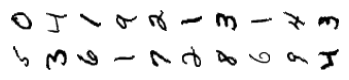

In [5]:
figure = plt.figure()
num_of_images = 20
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    reshaped = torch.reshape(tasks_tr[10][1][index], (28,28))
    plt.imshow(reshaped.numpy().squeeze(), cmap='gray_r')

## Loading the datasets

This function is used to load the MNIST dataset after applying the rotations and creating the new rotated MNIST data file.

In [6]:
def load_datasets(data_path, data_file):
    d_tr, d_te = torch.load(data_path + '/' + data_file)
    n_inputs = d_tr[0][1].size(1)
    n_outputs = 0
    for i in range(len(d_tr)):
        n_outputs = max(n_outputs, d_tr[i][2].max().item())
        n_outputs = max(n_outputs, d_te[i][2].max().item())
    return d_tr, d_te, n_inputs, n_outputs + 1, len(d_tr)

## Task changes

Here we create a helper function to keep track of the changes between tasks which will be useful in the construction of our confusion matrix.

In [7]:
def task_changes(result_t):
    n_tasks = int(result_t.max() + 1)
    changes = []
    current = result_t[0]
    for i, t in enumerate(result_t):
        if t != current:
            changes.append(i)
            current = t

    return n_tasks, changes

## Confusion matrix

Here we create a function that makes use of a confusion matrix in order to calculate the following metrix for evaluation of our GEM model: average accuracy, backward transfer, and forward transfer.

In [8]:
def confusion_matrix(result_t, result_a, fname=None):
    nt, changes = task_changes(result_t)

    baseline = result_a[0]
    changes = torch.LongTensor(changes + [result_a.size(0)]) - 1
    result = result_a[changes]

    # acc[t] equals result[t,t]
    acc = result.diag()
    fin = result[nt - 1]
    
    # bwt[t] equals result[T,t] - acc[t]
    bwt = result[nt - 1] - acc

    # fwt[t] equals result[t-1,t] - baseline[t]
    fwt = torch.zeros(nt)
    for t in range(1, nt):
        fwt[t] = result[t - 1, t] - baseline[t]

    if fname is not None:
        f = open(fname, 'w')

        print(' '.join(['%.4f' % r for r in baseline]), file=f)
        print('|', file=f)
        for row in range(result.size(0)):
            print(' '.join(['%.4f' % r for r in result[row]]), file=f)
        print('', file=f)
        # print('Diagonal Accuracy: %.4f' % acc.mean(), file=f)
        print('Final Accuracy: %.4f' % fin.mean(), file=f)
        print('Backward: %.4f' % bwt.mean(), file=f)
        print('Forward:  %.4f' % fwt.mean(), file=f)
        f.close()

    stats = []
    stats.append(fin.mean())
    stats.append(bwt.mean())
    stats.append(fwt.mean())

    return stats

## Multilayer perceptron

A multilayer perceptron (MLP) is a class of feedforward neural networks that consist of at least three layers of nodes: an input layer, a hidden layer, and an output layer. The hidden and output layers make use of nonlinear activation functions, and here we use ReLU for each. 

In [9]:
class MLP(nn.Module):
    def __init__(self, sizes):
        super(MLP, self).__init__()
        layers = []

        for i in range(0, len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1]))
            if i < (len(sizes) - 2):
                layers.append(nn.ReLU())

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

## GEM optimization functions

### i. ```store_grad```  
This stores parameter gradients of past tasks.

In [10]:
def store_grad(pp, grads, grad_dims, tid):
    # store the gradients
    grads[:, tid].fill_(0.0)
    cnt = 0
    for param in pp():
        if param.grad is not None:
            beg = 0 if cnt == 0 else sum(grad_dims[:cnt])
            en = sum(grad_dims[:cnt + 1])
            grads[beg: en, tid].copy_(param.grad.data.view(-1))
        cnt += 1

### ii. ```overwrite_grad```
This is used to overwrite the gradients with a new gradient vector whenever violations occur.

In [11]:
def overwrite_grad(pp, newgrad, grad_dims):
    cnt = 0
    for param in pp():
        if param.grad is not None:
            beg = 0 if cnt == 0 else sum(grad_dims[:cnt])
            en = sum(grad_dims[:cnt + 1])
            this_grad = newgrad[beg: en].contiguous().view(
                param.grad.data.size())
            param.grad.data.copy_(this_grad)
        cnt += 1

### iii. ```project2cone2```

Solves the GEM dual QP described in the paper given a proposed gradient "gradient", and a memory of task gradients "memories". Overwrites "gradient" with the final projected update.

In [12]:
def project2cone2(gradient, memories, margin=0.5, eps=1e-3):
    memories_np = memories.cpu().t().double().numpy()
    gradient_np = gradient.cpu().contiguous().view(-1).double().numpy()
    t = memories_np.shape[0]
    P = np.dot(memories_np, memories_np.transpose())
    P = 0.5 * (P + P.transpose()) + np.eye(t) * eps
    q = np.dot(memories_np, gradient_np) * -1
    G = np.eye(t)
    h = np.zeros(t) + margin
    v = quadprog.solve_qp(P, q, G, h)[0]
    x = np.dot(v, memories_np) + gradient_np
    gradient.copy_(torch.Tensor(x).view(-1, 1))

## Neural network

In [13]:
class Net(nn.Module):
    def __init__(self,
                 n_inputs,
                 n_outputs,
                 n_tasks,
                 n_layers, n_hiddens, memory_strength, lr, n_memories, cuda):
        super(Net, self).__init__()
        nl, nh = n_layers, n_hiddens
        self.margin = memory_strength
        self.net = MLP([n_inputs] + [nh] * nl + [n_outputs])

        self.ce = nn.CrossEntropyLoss()
        self.n_outputs = n_outputs

        self.opt = optim.SGD(self.parameters(), lr)

        self.n_memories = n_memories
        self.gpu = cuda

        # allocate episodic memory
        self.memory_data = torch.FloatTensor(
            n_tasks, self.n_memories, n_inputs)
        self.memory_labs = torch.LongTensor(n_tasks, self.n_memories)
        if cuda:
            self.memory_data = self.memory_data.cuda()
            self.memory_labs = self.memory_labs.cuda()

        # allocate temporary synaptic memory
        self.grad_dims = []
        for param in self.parameters():
            self.grad_dims.append(param.data.numel())
        self.grads = torch.Tensor(sum(self.grad_dims), n_tasks)
        if cuda:
            self.grads = self.grads.cuda()

        # allocate counters
        self.observed_tasks = []
        self.old_task = -1
        self.mem_cnt = 0
        self.nc_per_task = n_outputs

    def forward(self, x, t):
        output = self.net(x)
        return output

    def observe(self, x, t, y):
        # update memory
        if t != self.old_task:
            self.observed_tasks.append(t)
            self.old_task = t

        # Update ring buffer storing examples from current task
        bsz = y.data.size(0)
        endcnt = min(self.mem_cnt + bsz, self.n_memories)
        effbsz = endcnt - self.mem_cnt
        self.memory_data[t, self.mem_cnt: endcnt].copy_(
            x.data[: effbsz])
        if bsz == 1:
            self.memory_labs[t, self.mem_cnt] = y.data[0]
        else:
            self.memory_labs[t, self.mem_cnt: endcnt].copy_(
                y.data[: effbsz])
        self.mem_cnt += effbsz
        if self.mem_cnt == self.n_memories:
            self.mem_cnt = 0

        # compute gradient on previous tasks
        if len(self.observed_tasks) > 1:
            for tt in range(len(self.observed_tasks) - 1):
                self.zero_grad()
                # fwd/bwd on the examples in the memory
                past_task = self.observed_tasks[tt]

                offset1, offset2 = 0, self.nc_per_task
                ptloss = self.ce(
                    self.forward(
                        self.memory_data[past_task],
                        past_task)[:, offset1: offset2],
                    self.memory_labs[past_task] - offset1)
                ptloss.backward()
                store_grad(self.parameters, self.grads, self.grad_dims,
                           past_task)

        # now compute the grad on the current minibatch
        self.zero_grad()

        offset1, offset2 = 0, self.nc_per_task
        loss = self.ce(self.forward(x, t)[:, offset1: offset2], y - offset1)
        loss.backward()

        # check if gradient violates constraints
        if len(self.observed_tasks) > 1:
            # copy gradient
            store_grad(self.parameters, self.grads, self.grad_dims, t)
            indx = torch.cuda.LongTensor(self.observed_tasks[:-1]) if self.gpu \
                else torch.LongTensor(self.observed_tasks[:-1])
            dotp = torch.mm(self.grads[:, t].unsqueeze(0),
                            self.grads.index_select(1, indx))
            if (dotp < 0).sum() != 0:
                project2cone2(self.grads[:, t].unsqueeze(1),
                              self.grads.index_select(1, indx), self.margin)
                # copy gradients back
                overwrite_grad(self.parameters, self.grads[:, t],
                               self.grad_dims)
        self.opt.step()

## Loading the datasets

This function is used to load the MNIST dataset after applying the rotations and creating the new rotated MNIST data file.

In [14]:
def load_datasets(data_path, data_file):
    # d_tr, d_te = torch.load(data_path + '/' + data_file)
    d_tr, d_te = torch.load(data_file)
    n_inputs = d_tr[0][1].size(1)
    n_outputs = 0
    for i in range(len(d_tr)):
        n_outputs = max(n_outputs, d_tr[i][2].max().item())
        n_outputs = max(n_outputs, d_te[i][2].max().item())
    return d_tr, d_te, n_inputs, n_outputs + 1, len(d_tr)

## Continuum class


Here we create a mapping between each task and the number of samples specified to use for training the model (a sample is defined here as a subset of a certain task). These mappings are placed in an array which is then shuffled. This is repeated for a specified number of epochs.

In [15]:
class Continuum:

    def __init__(self, data, batch_size, shuffle_tasks, samples_per_task, n_epochs):
        self.data = data
        self.batch_size = batch_size
        n_tasks = len(data)
        task_permutation = range(n_tasks)

        if shuffle_tasks == 'yes':
            task_permutation = torch.randperm(n_tasks).tolist()

        sample_permutations = []

        for t in range(n_tasks):
            N = data[t][1].size(0)
            if samples_per_task <= 0:
                n = N
            else:
                n = min(samples_per_task, N)

            p = torch.randperm(N)[0:n]
            sample_permutations.append(p)

        self.permutation = []

        for t in range(n_tasks):
            task_t = task_permutation[t]
            for _ in range(n_epochs):
                task_p = [[task_t, i] for i in sample_permutations[task_t]]
                random.shuffle(task_p)
                self.permutation += task_p

        self.length = len(self.permutation)
        self.current = 0

    def __iter__(self):
        return self

    def next(self):
        return self.__next__()

    def __next__(self):
        if self.current >= self.length:
            raise StopIteration
        else:
            ti = self.permutation[self.current][0]
            j = []
            i = 0
            while (((self.current + i) < self.length) and
                   (self.permutation[self.current + i][0] == ti) and
                   (i < self.batch_size)):
                j.append(self.permutation[self.current + i][1])
                i += 1
            self.current += i
            j = torch.LongTensor(j)
            return self.data[ti][1][j], ti, self.data[ti][2][j]



## Evaluation of tasks

Here we create a function for evaluating the performance of each task. It returns the number of correct predictions by our model. This is later used to calculate the average accuracy, backward transfer, and forward transfer.

In [16]:
def eval_tasks(model, tasks, cuda):
    model.eval()
    result = []
    for i, task in enumerate(tasks):
        t = i
        x = task[1]
        y = task[2]
        rt = 0

        eval_bs = x.size(0)

        for b_from in range(0, x.size(0), eval_bs):
            b_to = min(b_from + eval_bs, x.size(0) - 1)
            if b_from == b_to:
                xb = x[b_from].view(1, -1)
                yb = torch.LongTensor([y[b_to]]).view(1, -1)
            else:
                xb = x[b_from:b_to]
                yb = y[b_from:b_to]
            if cuda:
                xb = xb.cuda()
            _, pb = torch.max(model(xb, t).data.cpu(), 1, keepdim=False)
            rt += (pb == yb).float().sum()

        result.append(rt / x.size(0))

    return result

## Life experience

This function does the following:

1. Iterates through the tasks/samples that were calculated in the ```continuum``` class
2. Trains the model for each task/sample
3. Calls ```eval_tasks``` after training each task and accumulates results
4. Returns these results for further processing by ```confusion_matrix``` along with the overall learning time

In [17]:
def life_experience(model, continuum, x_te, log_every, cuda):
    result_a = []
    result_t = []

    current_task = 0
    time_start = time.time()

    for (i, (x, t, y)) in enumerate(continuum):
        if (i % log_every) == 0 or t != current_task:
            result_a.append(eval_tasks(model, x_te, cuda))
            result_t.append(current_task)
            current_task = t

        v_x = x.view(x.size(0), -1)
        v_y = y.long()

        if cuda:
            v_x = v_x.cuda()
            v_y = v_y.cuda()

        model.train()
        model.observe(v_x, t, v_y)

    result_a.append(eval_tasks(model, x_te, cuda))
    result_t.append(current_task)

    time_end = time.time()
    time_spent = time_end - time_start

    return torch.Tensor(result_t), torch.Tensor(result_a), time_spent

## Main Function

In [18]:
model_name = "gem"
num_hidden_neurons = 100    # neurons per hidden layer
num_hidden_layers = 2
memories_per_task = 256
memory_strength = 0.5
epochs_per_task = 1
batch_size = 10
learning_rate = 0.1
cuda_enabled = True
random_seed = 0
log_frequency = 100
save_path = "results/"
data_path = "/kaggle/working"
data_file = "mnist_rotations.pt"
samples_per_task = 1000
shuffle_tasks = False

# initialize seeds
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
if cuda_enabled:
    torch.cuda.manual_seed_all(random_seed)

# load data
x_tr, x_te, n_inputs, n_outputs, n_tasks = load_datasets(data_path, data_file)

# set up continuum
continuum = Continuum(x_tr, batch_size, shuffle_tasks, samples_per_task, epochs_per_task)

# load model
model = Net(n_inputs, n_outputs, n_tasks,
                  num_hidden_layers, num_hidden_neurons, memory_strength, learning_rate, memories_per_task,
                  cuda_enabled)
if cuda_enabled:
    model.cuda()

# run model on continuum
result_t, result_a, spent_time = life_experience(
    model, continuum, x_te, log_frequency, cuda_enabled)

# prepare saving path and file name
# if not os.path.exists(save_path):
#     os.makedirs(save_path)

fname = model_name + '_' + data_file + '_'
fname += datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
# fname = os.path.join(save_path, fname)

# save confusion matrix and print one line of stats
stats = confusion_matrix(result_t, result_a, fname + '.txt')

acc = stats[0]
bwt = stats[1]
fwt = stats[2]

print("GEM results using rotated MNIST: average accuracy = {:.3f}, backward transfer = {:.3f}, forward transfer = {:.3f}".format(acc, bwt, fwt))
print("Time = {:.3f}".format(spent_time))

GEM results using rotated MNIST: average accuracy = 0.843, backward transfer = 0.005, forward transfer = 0.647
Time = 39.497


## Results

Let's visualize the results:

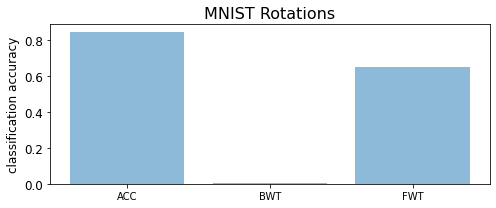

In [19]:
plt.figure(figsize=(7, 3))

metrics = ('ACC', 'BWT', 'FWT')
y_pos = np.arange(len(metrics))
plt.bar(y_pos, stats, align='center', alpha=0.5)
plt.xticks(y_pos, metrics)
plt.yticks(fontsize=12)
plt.ylabel('classification accuracy', fontsize=12)
plt.title('MNIST Rotations', fontsize=16)
plt.tight_layout()
plt.show()

The above results therefore shows that the GEM model classifies MNIST digits with high accuracy, demonstrates low catastrophic forgetting, and learns new tasks without sacrificing the performance of future tasks.

## Conclusion

GEM is known to perform significantly better than other continual learning methods while spending less computation. Its efficiency comes from optimizing over a number of variables equal to the number of tasks instead of optimizing over a number of variables equal to the number of parameters.

However, some limitations of GEM are:

1. Examples stored in the episodic memory may not be representative of past tasks
2. The inequality constraints appear to be rather restrictive for competing or conflicting tasks
3. The inequality constraints can only avoid forgetting but can not assure positive backward transfer